In [ ]:
def parse_data(file_path):
    """Parse the customer data from the provided file."""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Afficher les premières lignes pour vérifier le format
    print("First few lines of the file:")
    print(lines[:10])  # Afficher les 10 premières lignes pour déboguer

    # Vérifier si les lignes sont suffisantes
    if len(lines) < 6:
        raise ValueError("Le fichier ne contient pas assez de données")

    # Rechercher la ligne qui contient "VEHICLE"
    vehicle_index = next(i for i, line in enumerate(lines) if "VEHICLE" in line)
    # La capacité des véhicules se trouve deux lignes après "VEHICLE"
    try:
        vehicle_capacity = int(lines[vehicle_index + 2].split()[-1])  # Get vehicle capacity
    except IndexError:
        raise ValueError("Impossible de récupérer la capacité du véhicule à partir de la ligne attendue")

    customer_data = []

    # Rechercher la ligne qui contient "CUSTOMER" pour savoir où commencer
    customer_index = next(i for i, line in enumerate(lines) if "CUSTOMER" in line)
    
    # Extraire les données des clients à partir de la ligne suivante
    for line in lines[customer_index + 2:]:  # Commencer après l'entête "CUSTOMER"
        if line.strip():  # Si la ligne n'est pas vide
            data = line.split()
            if len(data) == 7:  # Vérifier qu'il y a bien 7 éléments sur la ligne
                customer_data.append({
                    'id': int(data[0]),
                    'x': float(data[1]),
                    'y': float(data[2]),
                    'demand': int(data[3]),
                    'ready_time': int(data[4]),
                    'due_date': int(data[5]),
                    'service_time': int(data[6])
                })
            else:
                print(f"Skipping invalid line: {line.strip()}")  # Afficher les lignes mal formatées

    return vehicle_capacity, customer_data

# Exemple de test
vehicle_capacity, customer_data = parse_data("../Dataset/c102.txt")

print(f"Vehicle Capacity: {vehicle_capacity}")
print(f"Customer Data: {customer_data}")


First few lines of the file:
['C102\n', '\n', 'VEHICLE\n', 'NUMBER     CAPACITY\n', '  25         200\n', '\n', 'CUSTOMER\n', 'CUST NO.  XCOORD.   YCOORD.    DEMAND   READY TIME  DUE DATE   SERVICE   TIME\n', ' \n', '    0      40         50          0          0       1236          0   \n']
Vehicle Capacity: 200
Customer Data: [{'id': 0, 'x': 40.0, 'y': 50.0, 'demand': 0, 'ready_time': 0, 'due_date': 1236, 'service_time': 0}, {'id': 1, 'x': 45.0, 'y': 68.0, 'demand': 10, 'ready_time': 0, 'due_date': 1127, 'service_time': 90}, {'id': 2, 'x': 45.0, 'y': 70.0, 'demand': 30, 'ready_time': 0, 'due_date': 1125, 'service_time': 90}, {'id': 3, 'x': 42.0, 'y': 66.0, 'demand': 10, 'ready_time': 0, 'due_date': 1129, 'service_time': 90}, {'id': 4, 'x': 42.0, 'y': 68.0, 'demand': 10, 'ready_time': 727, 'due_date': 782, 'service_time': 90}, {'id': 5, 'x': 42.0, 'y': 65.0, 'demand': 10, 'ready_time': 0, 'due_date': 1130, 'service_time': 90}, {'id': 6, 'x': 40.0, 'y': 69.0, 'demand': 20, 'ready_time'


Optimized Results:
Number of Trucks Used: 2

Truck 1 path: Depot -> 41 -> 20 -> 38 -> 64 -> 72 -> 89 -> 97 -> 4 -> 49 -> 17 -> 14 -> 24 -> 55 -> 98 -> 79 -> 84 -> 27 -> 71 -> 87 -> 22 -> 100 -> 62 -> 3 -> 63 -> 73 -> 2 -> 92 -> 69 -> 28 -> 59 -> 29 -> 65 -> 36 -> 43 -> 83 -> 18 -> 96 -> 7 -> 35 -> 39 -> 70 -> 90 -> 1 -> 42 -> 9 -> 15 -> 5 -> 48 -> 26 -> 56 -> 88 -> 45 -> Depot
  Cost (Distance): 1756.64 units
  Weight of goods when leaving depot: 888 units
  Weight of goods when returning to depot: 0 units

Truck 2 path: Depot -> 81 -> 85 -> 37 -> 66 -> 11 -> 74 -> 80 -> 99 -> 25 -> 30 -> 31 -> 82 -> 32 -> 95 -> 53 -> 51 -> 77 -> 76 -> 86 -> 19 -> 46 -> 21 -> 12 -> 75 -> 50 -> 40 -> 94 -> 13 -> 0 -> 78 -> 68 -> 33 -> 91 -> 23 -> 57 -> 8 -> 67 -> 34 -> 93 -> 54 -> 47 -> 61 -> 16 -> 6 -> 60 -> 52 -> 58 -> 10 -> 44 -> Depot
  Cost (Distance): 1272.02 units
  Weight of goods when leaving depot: 570 units
  Weight of goods when returning to depot: 0 units



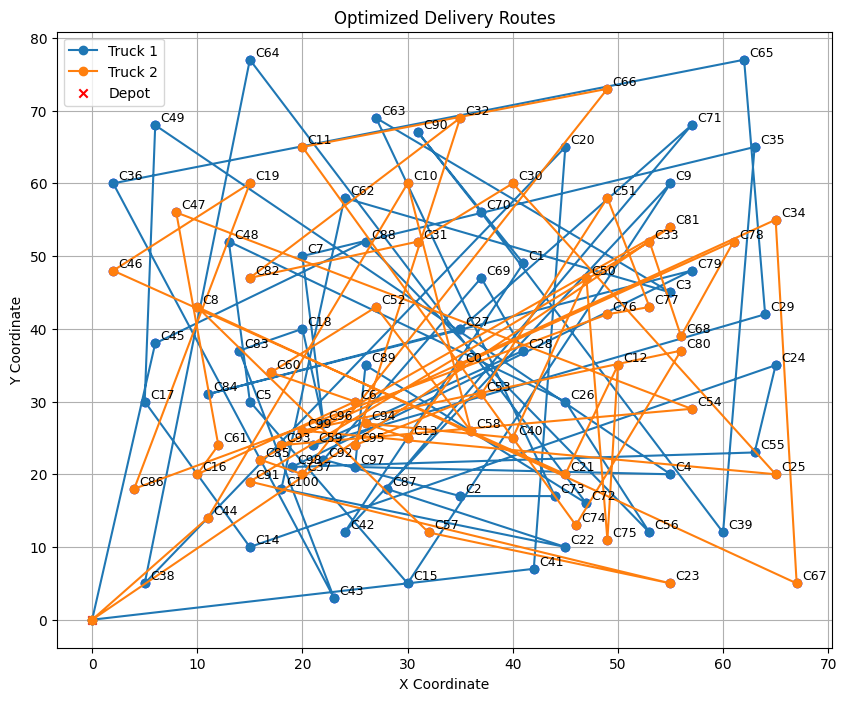

In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Step 1: Parse Data
def parse_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    vehicle_index = next(i for i, line in enumerate(lines) if "VEHICLE" in line)
    max_vehicles = int(lines[vehicle_index + 2].split()[0])  # Number of vehicles
    vehicle_capacity = int(lines[vehicle_index + 2].split()[1])  # Vehicle capacity
    customer_index = next(i for i, line in enumerate(lines) if "CUSTOMER" in line)
    customer_data = []
    for line in lines[customer_index + 2:]:
        if line.strip():
            data = line.split()
            if len(data) == 7:
                customer_data.append({
                    'id': int(data[0]),
                    'x': float(data[1]),
                    'y': float(data[2]),
                    'demand': int(data[3]),
                    'ready_time': int(data[4]),
                    'due_date': int(data[5]),
                    'service_time': int(data[6])
                })
    return max_vehicles, vehicle_capacity, customer_data

# Distance Calculation
def calculate_distance(p1, p2):
    return np.sqrt((p1['x'] - p2['x'])**2 + (p1['y'] - p2['y'])**2)

# Initial Solution
def create_initial_solution(customer_data, max_vehicles, vehicle_capacity):
    customers = customer_data.copy()
    random.shuffle(customers)
    routes = [[] for _ in range(max_vehicles)]
    vehicle_capacities = [vehicle_capacity] * max_vehicles
    for customer in customers:
        assigned = False
        for i in range(max_vehicles):
            if vehicle_capacities[i] >= customer['demand']:
                routes[i].append(customer)
                vehicle_capacities[i] -= customer['demand']
                assigned = True
                break
        if not assigned:
            raise ValueError("Not enough vehicles or capacity to serve all customers.")
    
    return [route for route in routes if route]

# Total Distance Calculation for each truck (individually)
def calculate_individual_truck_details(routes):
    truck_details = []  # To store cost and weight for each truck

    for route in routes:
        if len(route) == 0:
            continue
        
        route_distance = calculate_distance({'x': 0, 'y': 0}, route[0])  # From depot to first customer
        total_weight = sum(customer['demand'] for customer in route)  # Weight when leaving depot
        
        # Calculate the route distance and check if we arrive on time at each customer
        for i in range(len(route) - 1):
            route_distance += calculate_distance(route[i], route[i + 1])
        
        route_distance += calculate_distance(route[-1], {'x': 0, 'y': 0})  # Back to depot
        
        # Store truck details (cost, weight of goods when leaving depot, and weight of goods when returning to depot)
        truck_details.append({
            'cost': route_distance,  # Total distance (cost)
            'weight_out': total_weight,  # Weight of goods when leaving the depot
            'weight_in': 0  # Weight of goods when returning to depot (all goods delivered)
        })

    return truck_details



# Simulated Annealing
def simulated_annealing(customer_data, max_vehicles, vehicle_capacity, initial_temperature=1000, cooling_rate=0.995, iterations=10000):
    current_solution = create_initial_solution(customer_data, max_vehicles, vehicle_capacity)
    truck_details = calculate_individual_truck_details(current_solution)
    
    # If truck_details is empty, it means the solution was infeasible
    if not truck_details:
        return current_solution, truck_details

    best_solution = current_solution
    best_truck_details = truck_details
    best_cost = sum(details['cost'] for details in best_truck_details)  # Sum of individual truck costs

    temperature = initial_temperature
    for _ in range(iterations):
        new_solution = current_solution.copy()
        if len(new_solution) > 1:
            route1, route2 = random.sample(range(len(new_solution)), 2)
            if len(new_solution[route1]) > 0 and len(new_solution[route2]) > 0:
                customer1 = random.choice(new_solution[route1])
                new_solution[route1].remove(customer1)
                if sum(customer['demand'] for customer in new_solution[route2]) + customer1['demand'] <= vehicle_capacity:
                    new_solution[route2].append(customer1)

        # Remove empty routes
        new_solution = [route for route in new_solution if len(route) > 0]

        # Correct any missing customers
        served_customers = {customer['id'] for route in new_solution for customer in route}
        all_customers = {customer['id'] for customer in customer_data}
        missing_customers = all_customers - served_customers

        # Ensure there are enough routes to accommodate missing customers
        for missing_id in missing_customers:
            missing_customer = next(c for c in customer_data if c['id'] == missing_id)
            added = False
            for i in range(len(new_solution)):
                if sum(customer['demand'] for customer in new_solution[i]) + missing_customer['demand'] <= vehicle_capacity:
                    new_solution[i].append(missing_customer)
                    added = True
                    break
            if not added and len(new_solution) < max_vehicles:
                new_solution.append([missing_customer])

        truck_details = calculate_individual_truck_details(new_solution)
        
        # If truck_details is empty, the solution is infeasible
        if not truck_details:
            continue
        
        new_cost = sum(details['cost'] for details in truck_details)  # Sum of individual truck costs

        # Accept new solution based on temperature
        if new_cost < best_cost or random.random() < math.exp((best_cost - new_cost) / temperature):
            current_solution = new_solution
            best_cost = new_cost
            best_truck_details = truck_details

        temperature *= cooling_rate

    return best_solution, best_truck_details

# Print and plot truck details
def print_truck_paths(routes, truck_details):
    for i, (route, details) in enumerate(zip(routes, truck_details)):
        # Print the truck path and details
        customer_ids = [customer['id'] for customer in route]
        print(f"Truck {i + 1} path: Depot -> " + " -> ".join(map(str, customer_ids)) + " -> Depot")
        print(f"  Cost (Distance): {details['cost']:.2f} units")
        print(f"  Weight of goods when leaving depot: {details['weight_out']} units")
        print(f"  Weight of goods when returning to depot: {details['weight_in']} units")
        print()


def plot_routes(routes, customer_data):
    plt.figure(figsize=(10, 8))
    for customer in customer_data:
        plt.scatter(customer['x'], customer['y'], color='blue')
        plt.text(customer['x'] + 0.5, customer['y'] + 0.5, f"C{customer['id']}", fontsize=9)
    for route_idx, route in enumerate(routes):
        route_x = [customer['x'] for customer in route]
        route_y = [customer['y'] for customer in route]
        plt.plot([0] + route_x + [0], [0] + route_y + [0], marker='o', label=f"Truck {route_idx + 1}")
    plt.scatter(0, 0, color='red', marker='x', label="Depot")
    plt.title("Optimized Delivery Routes")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Execute
file_path = "../Dataset/r201.txt"  # Update path as necessary
max_vehicles, vehicle_capacity, customer_data = parse_data(file_path)
best_routes, truck_details = simulated_annealing(customer_data, max_vehicles, vehicle_capacity)

print("\nOptimized Results:")
print(f"Number of Trucks Used: {len(best_routes)}\n")
print_truck_paths(best_routes, truck_details)
plot_routes(best_routes, customer_data)
